In [1]:
import os
import json
import time
import datetime as dt
import numpy as np
import pandas as pd
import factoroid as fr
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

WebSQL = fr.connector.MySQLDB('db-01')
DevSQL = fr.connector.MySQLDB('db-dev')

Successfully connected; Factorid web services
Successfully connected; Factoroid development


In [2]:
sensor = WebSQL.filter_sensor(
    'EN', sort_values=['factory', 'number'],
    customer='율곡', factory='', zone='', equipment='ECO', location='',
    number=r'(\d{2})', type='CU', mac=''
)
sensor

table customer factory   zone          equipment network           mac  \
0     21       율곡      사천  사천생산1  ECOSPEED F1040 #2    21-B  CB245AD1F90D   
1     21       율곡      사천  사천생산1  ECOSPEED F1040 #2    21-B  D72B9E3889F1   
2     21       율곡      사천  사천생산1  ECOSPEED F1040 #2    21-B  E364DE80D1FA   

   number type  cycle  property location    comment  
0    1001   CU      2       600       메인  장비 캐비넷 내부  
1    1002   CU      2       600      스핀들  장비 캐비넷 내부  
2    1003   CU      2       100   스핀들/X축

In [38]:
mac = ['C31B89FC780C', 'D71A391481EA', 'EE9AB9A6A7E6']

In [39]:
data = {}
period_ = fr.utils.Period(['2022-04-13 08:00', '2022-04-14 08:00'])
for m in mac:
    row = WebSQL.get_data(mac=m, period=period_.utc)
    data_ = fr.processor.preprocess(row)
    data[m] = data_

In [51]:
df = data['C31B89FC780C'].copy()

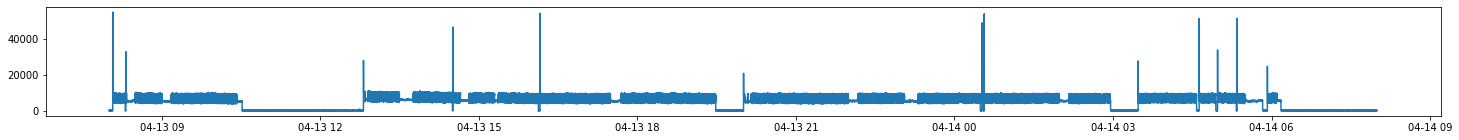

In [53]:
plt.figure(figsize=(25,2))
plt.plot(df.timestamp, df.value)
# plt.ylim(-1, 200)
plt.show()

In [54]:
times, y = df['timestamp'].values, df['value'].values
times_, y_ = [], []
previous = [times[0], y[0]]
for i in range(1, len(times)):
    while (times[i] - previous[0]) / np.timedelta64(1, 's') > 1:
        times_ += [previous[0]]
        y_ += [previous[1]]
        previous = [previous[0] + np.timedelta64(2,'s'), previous[1]]
    previous = [times[i], y[i]]
if (times[i] - times_[-1]) / np.timedelta64(1, 's') > 0.5: # add last element if feasible
    times_ += [times[i]]
    y_ += [y[i]]

In [55]:
from scipy import ndimage
from scipy import signal
y_ = ndimage.convolve1d(np.array(y_), weights=[1,3])
# y_ = ndimage.median_filter(np.array(y_), 5)
# min_threshold cutting
y_ = [max(1000, yy) for yy in y_]
m = np.percentile(y_, 99)
# normalize
y = [min(1, yy / m) for yy in y_]
times = times_.copy()
# y = list(1 - np.array(y))

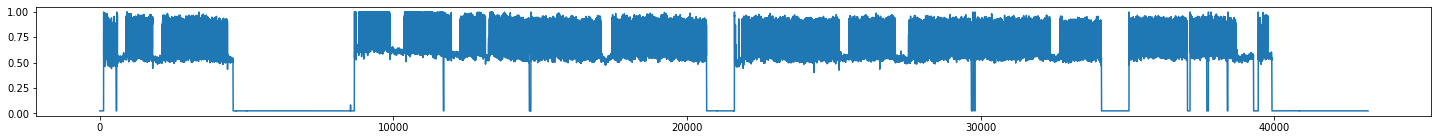

In [59]:
plt.figure(figsize=(25,2))
plt.plot(y)
plt.show()

In [36]:
# SO data load
# SO data merge
now = dt.datetime(2022, 4, 13, 8)

so = pd.DataFrame(WebSQL.query(f'''
                                    SELECT stop.equipment_name AS equipment_name, stop.order_number AS so, stop.gop AS gop, stop.material AS material, stop.qty AS qty, start.report_date AS start_time, MAX(stop.report_date) AS stop_time
                                    FROM so_log_yulkok AS stop
                                    LEFT JOIN (SELECT equipment_name, order_number, gop, material, qty, MIN(report_date) AS report_date
                                            FROM so_log_yulkok
                                            WHERE equipment_name IN ('G3020 #1', 'CMI 3S #8', 'DMC60T#3', 'DMU 50 3rd Generation #2', 'ECOSPEED F1040 #2', 'EVER 7', 
                                                                     'FMS ZT-800 #3', 'H5-800', 'HFP1540 PROTO', 'HU80A-5X', 'KT MODU LINE #3', 'MC18200 #1',
                                                                     'MP2150', 'MYNX500#1', 'SB-416', 'SNK RB-200F(2060)', 'VC630/5AX #S4', 'VMP8-6P', 'YK 3070(TCP-30TS)')
                                            AND status = '보고시작' AND report_date >= '{str(now - dt.timedelta(days=7))}' AND report_date <= '{str(now)}'
                                            GROUP BY equipment_name, order_number, gop, material, qty) AS start
                                            ON stop.equipment_name = start.equipment_name AND stop.order_number = start.order_number AND stop.gop = start.gop AND stop.material = start.material AND stop.qty = start.qty
                                    WHERE stop.equipment_name IN ('G3020 #1', 'CMI 3S #8', 'DMC60T#3', 'DMU 50 3rd Generation #2', 'ECOSPEED F1040 #2', 'EVER 7', 
                                                                  'FMS ZT-800 #3', 'H5-800', 'HFP1540 PROTO', 'HU80A-5X', 'KT MODU LINE #3', 'MC18200 #1',
                                                                  'MP2150', 'MYNX500#1', 'SB-416', 'SNK RB-200F(2060)', 'VC630/5AX #S4', 'VMP8-6P', 'YK 3070(TCP-30TS)')
                                    AND stop.status = '보고완료' AND stop.completion_flag = 'X' AND stop.report_date >= '{str(now - dt.timedelta(days=3))}' AND stop.report_date < '{str(now)}'
                                    GROUP BY equipment_name, so, gop, material, qty;
                                '''), columns=['equipment_name', 'so', 'gop', 'material', 'qty', 'start_time', 'stop_time', 'total_runtime'])

so.total_runtime = round((so.stop_time - so.start_time) / np.timedelta64(1,'h'), 3)
so = so.dropna().sort_values(by=['equipment_name', 'start_time']).reset_index(drop=True)
so = so[so.equipment_name == 'ECOSPEED F1040 #2']

In [24]:
log = pd.DataFrame(WebSQL.query('''

SELECT *
FROM yk_operating_log
WHERE equipment_name = 'ECOSPEED F1040 #2'

'''))

In [25]:
log_temp = log[(log.stop_time >= '2022-04-11 06:00') & (log.stop_time <= '2022-04-12 00:00')].reset_index(drop=True)

In [26]:
log_temp.loc[0, 'start_time'] = dt.datetime(2022,4,11,6)
log_temp.loc[34, 'stop_time'] = dt.datetime(2022,4,11,22)
log_temp.loc[4,'start_time'] = dt.datetime(2022,4,11,7,18,4)
log_temp.loc[1,'category'] = 'idle'
log_temp = log_temp.drop([2,3])

In [27]:
mac = 'D72B9E3889F1'
period_ = fr.utils.Period(['2022-04-11 06:00', '2022-04-11 22:00'])
row = WebSQL.get_data(mac=mac, period=period_.utc)
data_ = fr.processor.preprocess(row)

In [28]:
logs = [list(val) for val in log_temp[['start_time', 'stop_time', 'category']].values]

In [29]:
times, yy = data_.timestamp.values, data_.value.values

fig = go.Figure()
# fig.add_trace(go.Scatter(x=pd.to_datetime(times), y=yy, mode='lines', opacity=1, name='smooth', showlegend=False))
# for _, c in enumerate(cycles):
#     xx, yy = pd.to_datetime([aa[0] for aa in c]), [aa[1] for aa in c]
#     center_idx, max_yy = int(len(xx)//2), max(yy)
#     fig.add_trace(go.Scatter(x=xx, y=yy, mode='lines', name=f'{active_phase_idx}', line=dict(width=3)))
#     fig.add_trace(go.Scatter(x=[xx[center_idx]], y=[max_yy*1.1], mode='markers+text', text=f'{active_phase_idx}',
#                     textposition='middle center', textfont=dict(family='bold', color='black'),
#                     marker=dict(color='gray',opacity=0.2,size=15, line=dict(color='black', width=2)), showlegend=False))
#     active_phase_idx += 1
for log_ in logs:
    start_, end_, category_ = log_[0], log_[1], log_[2]
    
    temp_ = [[t, yy[idx]] for idx,t in enumerate(times) if start_<=t<end_]
    if category_ == 'off':
        fig.add_trace(go.Scatter(x=pd.to_datetime([t_[0] for t_ in temp_]), y=[t_[1] for t_ in temp_], mode='lines', line=dict(color='black'), name='off', opacity=0.7, showlegend=True))
        fig.add_vrect(x0=str(start_), x1=str(end_), opacity=0.2, fillcolor='black')
    elif category_ == 'idle':
        fig.add_trace(go.Scatter(x=pd.to_datetime([t_[0] for t_ in temp_]), y=[t_[1] for t_ in temp_], mode='lines', line=dict(color='red'), name='idle', opacity=0.7, showlegend=True))
        fig.add_vrect(x0=str(start_), x1=str(end_), opacity=0.2, fillcolor='red')
    elif category_ == 'idle_inter':
        fig.add_trace(go.Scatter(x=pd.to_datetime([t_[0] for t_ in temp_]), y=[t_[1] for t_ in temp_], mode='lines', line=dict(color='orange'), name='idle_inter', opacity=0.7, showlegend=True))
        fig.add_vrect(x0=str(start_), x1=str(end_), opacity=0.2, fillcolor='orange')
    elif category_ == 'operation':
        fig.add_trace(go.Scatter(x=pd.to_datetime([t_[0] for t_ in temp_]), y=[t_[1] for t_ in temp_], mode='lines', line=dict(color='green'), name='operation', opacity=0.7, showlegend=True))
        fig.add_vrect(x0=str(start_), x1=str(end_), opacity=0.2, fillcolor='green')
    elif category_ == 'exception':
        fig.add_trace(go.Scatter(x=pd.to_datetime([t_[0] for t_ in temp_]), y=[t_[1] for t_ in temp_], mode='lines', line=dict(color='blue'), name='exception', opacity=0.7, showlegend=True))
        fig.add_vrect(x0=str(start_), x1=str(end_), opacity=0.2, fillcolor='blue')
    names = set()
    fig.for_each_trace(lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=250, margin=dict(l=5,r=5,b=10,t=10,pad=2), legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0))
fig.show()

In [30]:
cycle = pd.DataFrame(WebSQL.query('''

SELECT *
FROM yk_operating_cycle
WHERE equipment_name = 'ECOSPEED F1040 #2'

'''))

In [31]:
cycle_temp = cycle[(cycle.stop_time >= '2022-04-11 06:00') & (cycle.stop_time <= '2022-04-12 00:00')].reset_index(drop=True)

In [32]:
cycles = [list(val) for val in cycle_temp[['start_time', 'stop_time']].values]

In [33]:
mac = 'D72B9E3889F1'
period_ = fr.utils.Period(['2022-04-11 06:00', '2022-04-11 22:00'])
row = WebSQL.get_data(mac=mac, period=period_.utc)
data_ = fr.processor.preprocess(row)

In [43]:
so = so[:5].copy().reset_index(drop=True)

In [44]:
so

equipment_name          so gop        material qty          start_time  \
0  ECOSPEED F1040 #2  D200600510  10  V5725352120800   1 2022-04-11 08:54:52   
1  ECOSPEED F1040 #2  D200593300  30  V5725352020400   1 2022-04-11 09:57:51   
2  ECOSPEED F1040 #2  D200600290  20  V5725352020400   1 2022-04-11 13:34:25   
3  ECOSPEED F1040 #2  D200600300  20  V5725352020400   1 2022-04-11 15:11:52   
4  ECOSPEED F1040 #2  D200600290  30  V5725352020400   1 2022-04-11 16:35:40   

            stop_time  total_runtime  
0 2022-04-11 09:57:40          1.047  
1 2022-04-11 13:34:16          3.607  
2 2022-04-11 14:48:48          1.240  
3 2022-04-11 16:35:29          1.394  
4 2022-04-11 19:37:21          3.028

In [55]:
times, yy = data_.timestamp.values, data_.value.values
active_phase_idx = 1

fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.to_datetime(times), y=yy, mode='lines', opacity=0.5, name='Signal', showlegend=True))
for _, c in enumerate(cycles):
    # names = set()
    start_, end_ = c[0], c[1]
    temp_ = [[t, yy[idx]] for idx,t in enumerate(times) if start_<=t<end_]
    xx ,yy_ = [t[0] for t in temp_], [t[1] for t in temp_]
    center_idx, max_yy = int(len(xx)//2), max(yy_)
    fig.add_trace(go.Scatter(x=pd.to_datetime(xx), y=yy_, mode='lines', name=f'Cycle_{active_phase_idx}', line=dict(width=3)))
    fig.add_trace(go.Scatter(x=pd.to_datetime([xx[center_idx]]), y=[max_yy*1.1], mode='markers+text', text=f'{active_phase_idx}',
                    textposition='middle center', textfont=dict(family='bold', color='black'),
                    marker=dict(color='gray',opacity=0.2,size=15, line=dict(color='black', width=2)), showlegend=False))
    active_phase_idx += 1

for _, so_ in so.iterrows():
    start_, end_ = so_.start_time, so_.stop_time
    fig.add_vrect(x0=str(start_), x1=str(end_), opacity=0.25, fillcolor='gray', name='SO')
    # fig.for_each_trace(lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=250, margin=dict(l=5,r=5,b=10,t=10,pad=2), legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0))
fig.show()

In [237]:
c = cycles[4]

In [238]:
start_, end_ = c[0], c[1]
temp_ = [[t, yy[idx]] for idx,t in enumerate(times) if start_<=t<end_]
xx ,yy_ = [t[0] for t in temp_], [t[1] for t in temp_]

In [248]:
temp = data_[(data_.timestamp >= '2022-04-11 16:23:30') & (data_.timestamp <= '2022-04-11 20:00')]

In [249]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.to_datetime(temp.timestamp), y=temp.value, mode='lines', opacity=0.5, name='Signal', showlegend=True))

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=250, margin=dict(l=5,r=5,b=10,t=10,pad=2), legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0))
fig.show()